In [1]:
import time
start_time = time.time()
import pandas as pd
import numpy as np
import nltk
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()  # for plot styling
import random


from sklearn.cluster import KMeans
from sklearn import cluster #needed for k-Means clustering
from sklearn import preprocessing #needed for scaling attributes to the nterval [0,1]
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from pytorch_pretrained_bert import BertTokenizer
from transformers import BertTokenizer, BertModel

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
sentence_tokenizer = nltk.tokenize.sent_tokenize

In [3]:
evaluation =False

# Load pre-trained model (weights)
model = BertModel.from_pretrained('bert-large-cased',
                                  output_hidden_states = True, # Whether the model returns all hidden-states.
                                  )

In [4]:
def transform(sentences, evaluation):
    i=1
    for sentence in sentences:

        # Add the special tokens.
        marked_text = "[CLS] " + sentence + " [SEP]"
        # Split the sentence into tokens.
        tokenized_text = tokenizer.tokenize(marked_text)
        # Map the token strings to their vocabulary indeces.
        indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)

        
        segments_ids = [1] * len(tokenized_text)
        #print (segments_ids)

        # Convert inputs to PyTorch tensors
        tokens_tensor = torch.tensor([indexed_tokens])
        segments_tensors = torch.tensor([segments_ids])

        if(evaluation ==False):
            # Put the model in "evaluation" mode, meaning feed-forward operation.
            model.eval()
            evaluation=True

            # Run the text through BERT, and collect all of the hidden states produced
            # from all 12 layers. 
        with torch.no_grad():

            outputs = model(tokens_tensor, segments_tensors)
            hidden_states = outputs[2]
        # `hidden_states` has shape [13 x 1 x 22 x 768]

        # `token_vecs` is a tensor with shape [22 x 768]
        token_vecs = hidden_states[-2][0]

        # Calculate the average of all 22 token vectors.
        sentence_embedding = torch.mean(token_vecs, dim=0)
        
        sentence_embedding = sentence_embedding.numpy()
        sentence_embedding = sentence_embedding.reshape(1,-1)
        sentence_embedding.shape
        sentence_embedding
        sentence_transformers.append(sentence_embedding)
        i=i+1
    return sentence_transformers

        


#  Source text can be supplied below

In [5]:
# Define a new example sentence with multiple meanings of the word "bank"
text = """

Dublin (/ˈdʌblɪn/, locally /ˈdʊb-/; Irish: Baile Átha Cliath[11] [ˈbˠalʲə aːhə ˈclʲiə; ˌbʲlʲaː ˈclʲiə]) is the capital and largest city of Ireland.[12][13] Situated on a bay on the east coast, at the mouth of the River Liffey, it lies within the province of Leinster. It is bordered on the south by the Dublin Mountains, a part of the Wicklow Mountains range. It has an urban area population of 1,173,179,[7] while the population of the Dublin Region (formerly County Dublin) as of 2016 was 1,347,359.[14] The population of the Greater Dublin Area was 1,904,806 per the 2016 census.[15]

There is archaeological debate regarding precisely where Dublin was established by the Gaels in or before the 7th century AD.[16] Later expanded as a Viking settlement, the Kingdom of Dublin, the city became Ireland's principal settlement following the Norman invasion.[16] The city expanded rapidly from the 17th century and was briefly the second largest city in the British Empire after the Acts of Union in 1800. Following the partition of Ireland in 1922, Dublin became the capital of the Irish Free State, later renamed Ireland.

Dublin is an historical and contemporary centre for education, the arts, administration and industry. As of 2018 the city was listed by the Globalization and World Cities Research Network (GaWC) as a global city, with a ranking of "Alpha minus", which places it amongst the top thirty cities in the world.

"""
sentence_transformers= []
sentences = sentence_tokenizer(text)
sentence_embeddings = transform(sentences, evaluation)



   

In [6]:
print("Num sentences:", len(sentences))
print(type(sentence_embeddings))

Num sentences: 11
<class 'list'>


In [7]:
for sentence, embedding in zip(sentences, sentence_embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

Sentence: 

Dublin (/ˈdʌblɪn/, locally /ˈdʊb-/; Irish: Baile Átha Cliath[11] [ˈbˠalʲə aːhə ˈclʲiə; ˌbʲlʲaː ˈclʲiə]) is the capital and largest city of Ireland.
Embedding: [[ 0.18925807 -0.3406061   0.16266924 ...  0.04080581 -0.04978079
   0.11027201]]

Sentence: [12][13] Situated on a bay on the east coast, at the mouth of the River Liffey, it lies within the province of Leinster.
Embedding: [[-0.22778521 -0.4932473   0.22299045 ... -0.06602822  0.22566816
   0.23998438]]

Sentence: It is bordered on the south by the Dublin Mountains, a part of the Wicklow Mountains range.
Embedding: [[-0.14970769 -0.09149433  0.10267873 ...  0.06761476  0.2277699
   0.12554245]]

Sentence: It has an urban area population of 1,173,179,[7] while the population of the Dublin Region (formerly County Dublin) as of 2016 was 1,347,359.
Embedding: [[ 0.00840508  0.03848826  0.11674463 ... -0.48626682  0.06740115
   0.21800192]]

Sentence: [14] The population of the Greater Dublin Area was 1,904,806 per the 2

In [8]:
sentence_embeddings = np.array(sentence_embeddings)
sentence_embeddings =sentence_embeddings.reshape(-1,1024)
print(sentence_embeddings.shape)

(11, 1024)


# Enter the amount of sentences you wished to have returned as a value of k below

In [9]:
pca = PCA(2)
features = pca.fit_transform(sentence_embeddings)
random_state: int = 0
k=3

In [10]:
model = KMeans(n_clusters=k, random_state=random_state).fit(features)
label = model.fit_predict(features)

<AxesSubplot:>

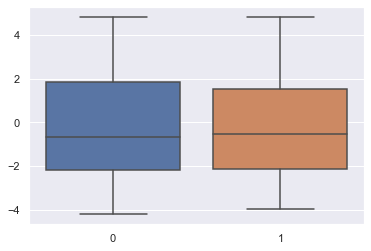

In [11]:
sns.boxplot(data=features)

In [12]:
#get centroids of kmeans
centroids = model.cluster_centers_

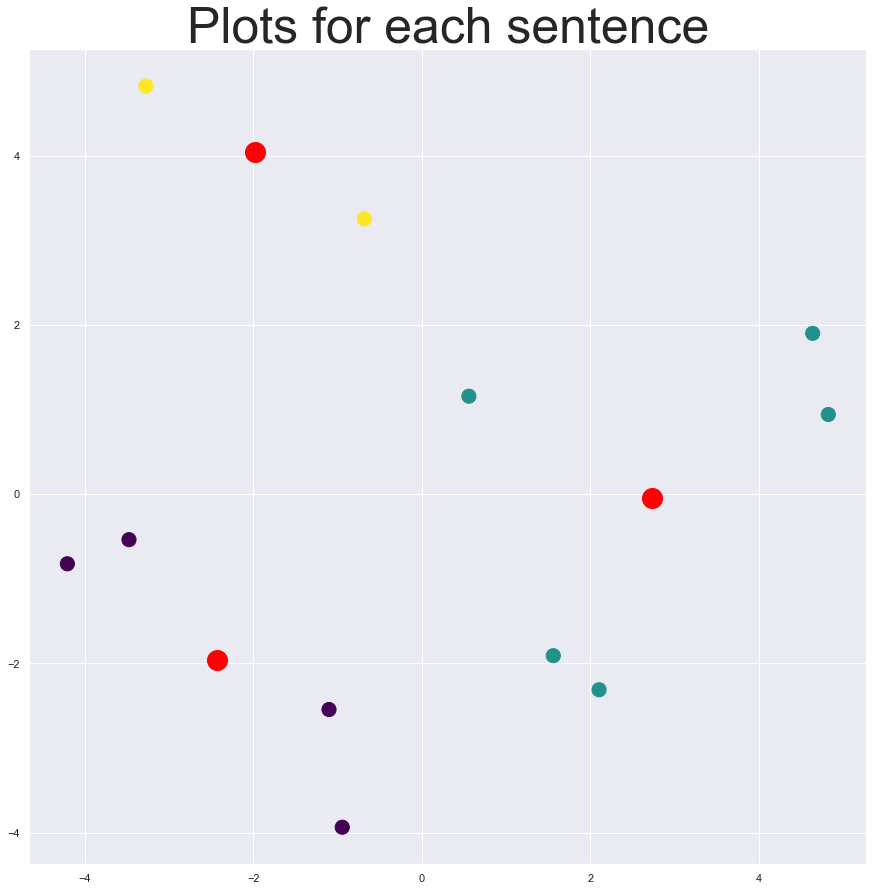

In [13]:
plt.figure(figsize=(15,15))
plt.title('Plots for each sentence', fontsize=50, ha='center')
plt.scatter(features[:,0], features[:,1], c=label, s=200, cmap='viridis')
plt.savefig('ScatterPlot_08.png')
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', s=400, alpha=0.99);

In [14]:
#cluster_args  by k
centroid_min = .4e10
cur_arg = -1
args = {}
used_idx = []

for j, centroid in enumerate(centroids):

    for i, feature in enumerate(features):
        value = np.linalg.norm(feature - centroid)


        if value < centroid_min and i not in used_idx:
            cur_arg = i
            centroid_min = value

    used_idx.append(cur_arg)
    args[j] = cur_arg
    centroid_min = .4e10
    cur_arg = -1
print(args.values())

dict_values([0, 7, 2])


In [15]:
sorted_values =sorted(args.values())

In [16]:
print(sorted_values)

[0, 2, 7]


In [17]:
type(sentences)

list

In [18]:
i =0
for i , sentence in enumerate(sorted_values):
    print("Sentence ", i+1, " ",sentences[sentence], "\n")


Sentence  1   

Dublin (/ˈdʌblɪn/, locally /ˈdʊb-/; Irish: Baile Átha Cliath[11] [ˈbˠalʲə aːhə ˈclʲiə; ˌbʲlʲaː ˈclʲiə]) is the capital and largest city of Ireland. 

Sentence  2   It is bordered on the south by the Dublin Mountains, a part of the Wicklow Mountains range. 

Sentence  3   [16] The city expanded rapidly from the 17th century and was briefly the second largest city in the British Empire after the Acts of Union in 1800. 



In [19]:

result = []
for i , sentence in enumerate(sorted_values):
    s = sentences[sentence]
    result.append(s)
    result.append("\n")

s ='\n'.join(result)


In [20]:
print(s)



Dublin (/ˈdʌblɪn/, locally /ˈdʊb-/; Irish: Baile Átha Cliath[11] [ˈbˠalʲə aːhə ˈclʲiə; ˌbʲlʲaː ˈclʲiə]) is the capital and largest city of Ireland.


It is bordered on the south by the Dublin Mountains, a part of the Wicklow Mountains range.


[16] The city expanded rapidly from the 17th century and was briefly the second largest city in the British Empire after the Acts of Union in 1800.




In [21]:
print("My program took", time.time() - start_time, "to run")

My program took 23.50220251083374 to run
